In [1]:
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
from shapely.geometry import Point
import random
from pathlib import Path
import ee
from datetime import datetime, timedelta
import sys
import rootutils

root_path = rootutils.find_root()

def initialize_gee():
    """Initialize Google Earth Engine"""
    print("🌍 Initializing Google Earth Engine...")
    try:
        ee.Initialize()
        print("✓ Google Earth Engine initialized successfully")
    except Exception as e:
        print(f"✗ Failed to initialize GEE: {e}")
        print("Please authenticate with: earthengine authenticate")
        sys.exit(1)

def find_radd_tile_for_event(lat, lon, tile_mapping_file=None):
    """
    Find which RADD tile contains the given lat/lon coordinates
    
    Args:
        lat, lon: Event coordinates
        tile_mapping_file: Optional path to tile boundaries file
        
    Returns:
        tile_id: String identifier like "10S_050W"
    """
    print(f"🗺️  Finding RADD tile for coordinates: {lat:.4f}, {lon:.4f}")
    
    # If we have tile boundaries, use them
    if tile_mapping_file and Path(tile_mapping_file).exists():
        print("    Using tile boundary file for precise tile identification")
        tiles_gdf = gpd.read_file(tile_mapping_file)
        point = Point(lon, lat)
        
        for idx, tile in tiles_gdf.iterrows():
            if tile.geometry.contains(point):
                print(f"    Found tile via boundary file: {tile['tile_id']}")
                return tile['tile_id']
    
    # Fallback: Estimate tile from coordinates
    print("    Using coordinate-based tile estimation (10x10 degree grid)")
    # RADD tiles are typically 10x10 degree squares
    lat_deg = int(np.floor(lat / 10) * 10)
    lon_deg = int(np.floor(lon / 10) * 10)
    
    # Format as RADD tile naming convention
    lat_suffix = "N" if lat_deg >= 0 else "S"
    lon_suffix = "E" if lon_deg >= 0 else "W"
    
    tile_id = f"{abs(lat_deg):02d}{lat_suffix}_{abs(lon_deg):03d}{lon_suffix}"
    print(f"    Estimated tile ID: {tile_id}")
    return tile_id

def load_radd_tile_data(tile_id, radd_base_dir="data/raw/radd/south_america"):
    """
    Load RADD raster data for a specific tile
    
    Args:
        tile_id: Tile identifier like "10S_050W"
        radd_base_dir: Base directory containing RADD tiles
        
    Returns:
        raster_data: numpy array with RADD alert data
        transform: Rasterio transform object
        crs: Coordinate reference system
    """
    print(f"📁 Loading RADD tile data for: {tile_id}")
    radd_file = Path(radd_base_dir) / f"{tile_id}_radd_alerts.tif"
    
    print(f"    Looking for file: {radd_file}")
    if not radd_file.exists():
        print(f"    ✗ File not found!")
        raise FileNotFoundError(f"RADD tile file not found: {radd_file}")
    
    print("    Opening raster file...")
    with rasterio.open(radd_file) as src:
        print(f"    Reading raster data (shape: {src.shape}, CRS: {src.crs})")
        raster_data = src.read(1)
        transform = src.transform
        crs = src.crs
    
    print(f"✓ Loaded RADD tile {tile_id}: {raster_data.shape}")
    print(f"    Non-zero pixels: {np.count_nonzero(raster_data)}")
    return raster_data, transform, crs

def pixel_to_coordinates(row, col, transform):
    """Convert pixel coordinates to lat/lon"""
    x, y = rasterio.transform.xy(transform, row, col)
    return y, x  # lat, lon

def coordinates_to_pixel(lat, lon, transform):
    """Convert lat/lon to pixel coordinates"""
    row, col = rasterio.transform.rowcol(transform, lon, lat)
    return row, col

def extract_temporal_alerts(radd_data, earliest_alert, latest_alert, safety_buffer_months=2):
    """
    Extract RADD alerts that occurred during the specified time period + safety buffer
    
    Args:
        radd_data: RADD raster data (encoded with dates)
        earliest_alert: Start date of deforestation period
        latest_alert: End date of deforestation period
        safety_buffer_months: Additional months before/after to avoid (default: 2)
        
    Returns:
        temporal_mask: Boolean array indicating pixels with alerts in extended period
    """
    print(f"⏰ Extracting temporal alerts for period: {earliest_alert} to {latest_alert}")
    
    # RADD encoding: value = confidence_level * 10000 + days_since_dec31_2014
    def date_to_radd_days(date_str):
        """Convert date string to RADD day encoding"""
        base_date = datetime(2014, 12, 31)
        target_date = datetime.strptime(date_str, "%Y-%m-%d")
        return (target_date - base_date).days
    
    # Add safety buffer to the time period
    print(f"    Parsing dates and adding {safety_buffer_months} month safety buffer...")
    earliest_date = datetime.strptime(earliest_alert, "%Y-%m-%d")
    latest_date = datetime.strptime(latest_alert, "%Y-%m-%d")
    
    # Extend period by safety buffer (2 months = ~60 days)
    safety_buffer_days = safety_buffer_months * 30
    extended_start = earliest_date - timedelta(days=safety_buffer_days)
    extended_end = latest_date + timedelta(days=safety_buffer_days)
    
    print(f"    Original period: {earliest_alert} to {latest_alert}")
    print(f"    Extended period (with buffer): {extended_start.strftime('%Y-%m-%d')} to {extended_end.strftime('%Y-%m-%d')}")
    
    start_days = date_to_radd_days(extended_start.strftime("%Y-%m-%d"))
    end_days = date_to_radd_days(extended_end.strftime("%Y-%m-%d"))
    
    print(f"    Converting to RADD day encoding: {start_days} to {end_days}")
    
    # Extract day component from RADD data
    print("    Analyzing RADD pixel values...")
    valid_mask = radd_data > 0
    day_component = radd_data % 10000
    
    print(f"    Valid pixels in raster: {np.count_nonzero(valid_mask)}")
    
    # Create temporal mask for alerts in the EXTENDED period (for avoidance)
    temporal_mask = valid_mask & (day_component >= start_days) & (day_component <= end_days)
    alert_pixel_count = np.count_nonzero(temporal_mask)
    
    print(f"    Pixels with alerts in extended period: {alert_pixel_count}")
    print(f"    Alert density: {alert_pixel_count / np.count_nonzero(valid_mask) * 100:.2f}% of valid pixels")
    
    return temporal_mask

def check_forest_cover_gee(lat, lon, date_str, forest_threshold=0.3):
    """
    Check if location has sufficient forest cover using Google Earth Engine
    
    Args:
        lat, lon: Coordinates to check
        date_str: Date for forest cover assessment (format: "YYYY-MM-DD")
        forest_threshold: Minimum forest fraction required
        
    Returns:
        is_forested: Boolean indicating if location meets forest criteria
        forest_fraction: Actual forest fraction at location
    """
    print(f"🌳 Checking forest cover at {lat:.4f}, {lon:.4f} for date {date_str}")
    
    # Create point geometry
    point = ee.Geometry.Point([lon, lat])
    
    # Use Dynamic World for forest cover
    # Get closest date to our target
    target_date = datetime.strptime(date_str, "%Y-%m-%d")
    start_date = (target_date - timedelta(days=30)).strftime("%Y-%m-%d")
    end_date = (target_date + timedelta(days=30)).strftime("%Y-%m-%d")
    
    print(f"    Searching Dynamic World data from {start_date} to {end_date}")
    
    # Load Dynamic World data
    dw = ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1") \
           .filterBounds(point) \
           .filterDate(start_date, end_date) \
           .select('label')
    
    available_images = dw.size().getInfo()
    print(f"    Found {available_images} Dynamic World images")
    
    if available_images == 0:
        print(f"⚠️  No Dynamic World data available for {lat:.4f}, {lon:.4f} around {date_str}")
        return False, 0.0
    
    # Get the most recent image
    print("    Using most recent available image...")
    latest_image = dw.sort('system:time_start', False).first()
    
    # Extract forest class (class 1 = trees/forest)
    print("    Extracting forest pixels (class 1 = trees)...")
    forest_mask = latest_image.eq(1)
    
    # Calculate forest fraction in 128x128 pixel buffer around point
    # Assuming 10m resolution, 128 pixels = 1.28km buffer
    buffer_size = 1280  # meters (128 pixels * 10m)
    buffer_region = point.buffer(buffer_size)
    
    print(f"    Calculating forest fraction in {buffer_size}m buffer...")
    
    # Calculate forest fraction
    forest_stats = forest_mask.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=buffer_region,
        scale=10,
        maxPixels=1e6
    )
    
    forest_fraction = forest_stats.getInfo().get('label', 0)
    is_forested = forest_fraction >= forest_threshold
    
    print(f"    Forest fraction: {forest_fraction:.3f}")
    print(f"    Meets threshold ({forest_threshold}): {'YES' if is_forested else 'NO'}")
    
    return is_forested, forest_fraction

def sample_negative_location_within_tile(positive_lat, positive_lon, tile_id, 
                                       radd_data, transform, earliest_alert, latest_alert,
                                       max_attempts=50, min_distance_km=5, safety_buffer_months=2):
    """
    Sample a negative location within the same RADD tile
    
    Args:
        positive_lat, positive_lon: Coordinates of positive deforestation event
        tile_id: RADD tile identifier
        radd_data: RADD raster data for the tile
        transform: Rasterio transform for the tile
        earliest_alert, latest_alert: Time period to avoid RADD alerts
        max_attempts: Maximum sampling attempts
        min_distance_km: Minimum distance from positive event (km)
        safety_buffer_months: Extra months before/after to avoid alerts (default: 2)
        
    Returns:
        negative_sample: Dict with negative sample info or None if failed
    """
    print(f"🎯 Sampling negative location within tile {tile_id}")
    print(f"    Positive event at: {positive_lat:.4f}, {positive_lon:.4f}")
    print(f"    Constraints: >{min_distance_km}km away, no alerts in extended period, forest cover >30%")
    
    # Get tile boundaries (approximate 10x10 degree tile)
    tile_height, tile_width = radd_data.shape
    print(f"    Tile dimensions: {tile_height} x {tile_width} pixels")
    
    # Get temporal mask for the EXTENDED deforestation period (original + 2 month buffer)
    print("    Getting temporal alert mask for extended period...")
    temporal_alert_mask = extract_temporal_alerts(
        radd_data, earliest_alert, latest_alert, safety_buffer_months
    )
    
    # Convert minimum distance to pixels (approximate)
    min_distance_pixels = int(min_distance_km * 1000 / 10)  # Assuming ~10m pixel size
    print(f"    Minimum distance: {min_distance_km}km = {min_distance_pixels} pixels")
    
    # Convert positive event coordinates to pixel coordinates
    pos_row, pos_col = coordinates_to_pixel(positive_lat, positive_lon, transform)
    print(f"    Positive event pixel location: row {pos_row}, col {pos_col}")
    
    print(f"    Starting sampling (max {max_attempts} attempts)...")
    
    for attempt in range(max_attempts):
        if (attempt + 1) % 10 == 0:
            print(f"      Attempt {attempt + 1}/{max_attempts}...")
        
        # Sample random pixel within tile
        rand_row = random.randint(64, tile_height - 64)  # Leave 64 pixel buffer from edges
        rand_col = random.randint(64, tile_width - 64)
        
        # Check if this pixel has alerts during the EXTENDED time period
        if temporal_alert_mask[rand_row, rand_col]:
            continue  # Skip - has deforestation alerts in extended period
        
        # Convert to coordinates
        sample_lat, sample_lon = pixel_to_coordinates(rand_row, rand_col, transform)
        
        # Check minimum distance from positive event
        distance_pixels = np.sqrt((rand_row - pos_row)**2 + (rand_col - pos_col)**2)
        
        if distance_pixels < min_distance_pixels:
            continue  # Too close to positive event
        
        # Check forest cover using GEE
        try:
            print(f"      Checking candidate at {sample_lat:.4f}, {sample_lon:.4f}")
            is_forested, forest_fraction = check_forest_cover_gee(
                sample_lat, sample_lon, earliest_alert, forest_threshold=0.2
            )
            
            if is_forested:
                distance_km = distance_pixels * 10 / 1000
                print(f"  ✓ Found suitable negative sample at attempt {attempt + 1}")
                print(f"    Coordinates: {sample_lat:.4f}, {sample_lon:.4f}")
                print(f"    Forest fraction: {forest_fraction:.3f}")
                print(f"    Distance: {distance_km:.1f} km from positive event")
                print(f"    No RADD alerts in extended period ({safety_buffer_months} month buffer)")
                
                return {
                    'lat': sample_lat,
                    'lon': sample_lon,
                    'tile_id': tile_id,
                    'forest_fraction': forest_fraction,
                    'distance_km': distance_km,
                    'earliest_alert': earliest_alert,
                    'latest_alert': latest_alert,
                    'safety_buffer_months': safety_buffer_months,
                    'is_deforestation': False,
                    'attempt_number': attempt + 1
                }
            else:
                print(f"        Rejected: insufficient forest cover ({forest_fraction:.3f})")
            
        except Exception as e:
            print(f"    ⚠️  Error checking forest cover at attempt {attempt + 1}: {e}")
            continue
    
    print(f"  ✗ Failed to find suitable negative sample after {max_attempts} attempts")
    return None

def generate_negative_samples_for_all_events(deforest_df, output_file=None, 
                                           radd_base_dir="data/raw/radd/south_america"):
    """
    Generate negative samples for all deforestation events
    
    Args:
        deforest_df: DataFrame with positive deforestation events
        output_file: Path to save negative samples CSV
        radd_base_dir: Directory containing RADD tiles
        
    Returns:
        negative_samples_df: DataFrame with negative samples
    """
    print("🚀 Starting negative sample generation process")
    print(f"📊 Input: {len(deforest_df)} deforestation events")
    print(f"📂 RADD data directory: {radd_base_dir}")
    if output_file:
        print(f"💾 Output file: {output_file}")
    
    initialize_gee()
    
    negative_samples = []
    tile_cache = {}  # Cache loaded tiles
    
    print(f"\n🔄 Processing {len(deforest_df)} deforestation events")
    print("=" * 60)
    
    for idx, event in deforest_df.iterrows():
        print(f"\n📍 Processing event {idx + 1}/{len(deforest_df)}")
        print(f"  Positive event: {event['centroid_y']:.4f}, {event['centroid_x']:.4f}")
        print(f"  Time period: {event['earliest_alert']} to {event['latest_alert']}")
        if 'area_hectares' in event:
            print(f"  Area: {event['area_hectares']:.1f} hectares")
        if 'duration_days' in event:
            print(f"  Duration: {event['duration_days']} days")
        
        # Find RADD tile for this event
        tile_id = find_radd_tile_for_event(event['centroid_y'], event['centroid_x'])
        
        # Load tile data (use cache if available)
        if tile_id not in tile_cache:
            try:
                print(f"  Loading new tile: {tile_id}")
                radd_data, transform, crs = load_radd_tile_data(tile_id, radd_base_dir)
                tile_cache[tile_id] = (radd_data, transform, crs)
                print(f"  ✓ Tile loaded and cached")
            except FileNotFoundError as e:
                print(f"  ✗ {e}")
                continue
        else:
            radd_data, transform, crs = tile_cache[tile_id]
            print(f"  ✓ Using cached tile data for {tile_id}")
        
        # Sample negative location
        print(f"  🎲 Starting negative sampling...")
        negative_sample = sample_negative_location_within_tile(
            event['centroid_y'], event['centroid_x'], tile_id,
            radd_data, transform, 
            event['earliest_alert'], event['latest_alert']
        )
        
        if negative_sample:
            print(f"  ✅ Successfully generated negative sample")
            # Add event reference information
            negative_sample['positive_event_id'] = idx
            negative_sample['positive_lat'] = event['centroid_y']
            negative_sample['positive_lon'] = event['centroid_x']
            negative_sample['positive_area_hectares'] = event.get('area_hectares', np.nan)
            negative_sample['positive_duration_days'] = event.get('duration_days', np.nan)
            
            negative_samples.append(negative_sample)
        else:
            print(f"  ❌ Failed to generate negative sample for this event")
        
        # Progress update
        if (idx + 1) % 10 == 0:
            success_rate = len(negative_samples) / (idx + 1) * 100
            print(f"\n📈 Progress update:")
            print(f"  Completed: {idx + 1}/{len(deforest_df)} events")
            print(f"  Successful samples: {len(negative_samples)}")
            print(f"  Success rate: {success_rate:.1f}%")
            print(f"  Cached tiles: {len(tile_cache)}")
    
    # Convert to DataFrame
    print(f"\n📋 Creating final DataFrame...")
    negative_samples_df = pd.DataFrame(negative_samples)
    
    if len(negative_samples_df) > 0:
        print(f"\n🎉 Negative sampling completed successfully!")
        print(f"✓ Generated {len(negative_samples_df)} negative samples")
        print(f"✓ Overall success rate: {len(negative_samples_df) / len(deforest_df) * 100:.1f}%")
        print(f"✓ Used {len(tile_cache)} unique RADD tiles")
        
        # Display sample statistics
        if 'forest_fraction' in negative_samples_df.columns:
            print(f"✓ Average forest fraction: {negative_samples_df['forest_fraction'].mean():.3f}")
        if 'distance_km' in negative_samples_df.columns:
            print(f"✓ Average distance from positive events: {negative_samples_df['distance_km'].mean():.1f} km")
        
        # Save if output file specified
        if output_file:
            print(f"\n💾 Saving results to file...")
            negative_samples_df.to_csv(output_file, index=False)
            print(f"✓ Saved negative samples to: {output_file}")
    else:
        print("\n❌ No negative samples generated")
        print("   Check RADD data availability and forest cover thresholds")
    
    return negative_samples_df

print("🔧 Loading deforestation events dataset...")
# Load deforestation events
deforest_df = pd.read_parquet(root_path / "data/processed/radd/south_america_combined_clean.parquet")
print(f"✓ Loaded {len(deforest_df)} deforestation events")

print("\n🎯 Starting negative sample generation (first 50 events for testing)...")
# Generate negative samples
negative_samples_df = generate_negative_samples_for_all_events(
    deforest_df.head(50),  # Start with first 50 events for testing
    output_file=root_path / "data/processed/radd/negative_samples.csv"
)

print("\n🏁 Negative sampling process complete!")
if len(negative_samples_df) > 0:
    print(f"Final results saved to: {root_path / 'data/processed/radd/negative_samples.csv'}")
else:
    print("No samples were successfully generated. Check logs above for issues.")

🔧 Loading deforestation events dataset...
✓ Loaded 1588 deforestation events

🎯 Starting negative sample generation (first 50 events for testing)...
🚀 Starting negative sample generation process
📊 Input: 50 deforestation events
📂 RADD data directory: data/raw/radd/south_america
💾 Output file: /net/home/lmaecker/own_projects/burned_embedder/data/processed/radd/negative_samples.csv
🌍 Initializing Google Earth Engine...
✓ Google Earth Engine initialized successfully

🔄 Processing 50 deforestation events

📍 Processing event 1/50
  Positive event: -8.1509, -49.4877
  Time period: 2021-08-29 to 2021-09-22
  Area: 1.3 hectares
  Duration: 24 days
🗺️  Finding RADD tile for coordinates: -8.1509, -49.4877
    Using coordinate-based tile estimation (10x10 degree grid)
    Estimated tile ID: 10S_050W
  Loading new tile: 10S_050W
📁 Loading RADD tile data for: 10S_050W
    Looking for file: data/raw/radd/south_america/10S_050W_radd_alerts.tif
    Opening raster file...
    Reading raster data (shape

In [4]:
deforest_df = pd.read_parquet(root_path / "data/processed/radd/south_america_combined_clean.parquet")
deforest_df

,geometry,tile_name,sample_id,component_id,size_pixels,area_hectares,earliest_alert,latest_alert,duration_days,centroid_x,centroid_y,confidence,date_raster_file
0,b'\x01\x01\x00\x00\x00\x03\x16k;l\xbeH\xc0QXZ\...,00N_050W_radd_alerts,sample_07,32,109,1.342989,2021-08-29,2021-09-22,24,-49.487678,-8.150868,high,sample_07_dates.tif
1,b'\x01\x01\x00\x00\x00zw\xf0\xf05\xcdH\xc0\r\x...,00N_050W_radd_alerts,sample_07,111,312,3.844152,2025-05-16,2025-06-09,24,-49.603209,-8.475450,high,sample_07_dates.tif
2,b'\x01\x01\x00\x00\x00\x9a\xb2\xaf\x7f\xd3PF\x...,00N_050W_radd_alerts,sample_11,33,158,1.946718,2024-10-14,2024-11-07,24,-44.631454,-5.697680,high,sample_11_dates.tif
3,b'\x01\x01\x00\x00\x00\x91\xee\x8f@\x06kF\xc0\...,00N_050W_radd_alerts,sample_11,145,106,1.306026,2022-11-06,2022-11-18,12,-44.836128,-5.717239,high,sample_11_dates.tif
4,b'\x01\x01\x00\x00\x00\xd4\x18\xdb\x13NMF\xc0\...,00N_050W_radd_alerts,sample_11,194,126,1.552446,2021-09-19,2021-09-19,0,-44.603945,-5.726981,high,sample_11_dates.tif
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1583,b'\x01\x01\x00\x00\x00\xc9\xed\x84\x84\x15\xed...,20S_060W_radd_alerts,sample_26,535,120,1.478520,2021-09-26,2021-10-20,24,-57.852219,-22.696022,high,sample_26_dates.tif
1584,b'\x01\x01\x00\x00\x00\xdcD\x82m\xa8\xfbL\xc0\...,20S_060W_radd_alerts,sample_26,612,329,4.053609,2021-09-14,2021-10-08,24,-57.966078,-22.769136,high,sample_26_dates.tif
1585,b'\x01\x01\x00\x00\x00\xaa\xfc\xca\xb7$\xfcL\x...,20S_060W_radd_alerts,sample_26,615,129,1.589409,2021-09-14,2021-10-08,24,-57.969871,-22.770695,high,sample_26_dates.tif
1586,b'\x01\x01\x00\x00\x00\x98\x86\xe1#b\xfcL\xc0c...,20S_060W_radd_alerts,sample_26,617,220,2.710620,2021-09-14,2021-10-08,24,-57.971745,-22.772191,high,sample_26_dates.tif


🎨 Creating negative samples visualization...
📊 Creating visualization from: /net/home/lmaecker/own_projects/burned_embedder/data/processed/radd/negative_samples.csv
✓ Loaded 50 negative samples
✓ Visualization saved to: /net/home/lmaecker/own_projects/burned_embedder/data/interim/negative_samples_visualization.png


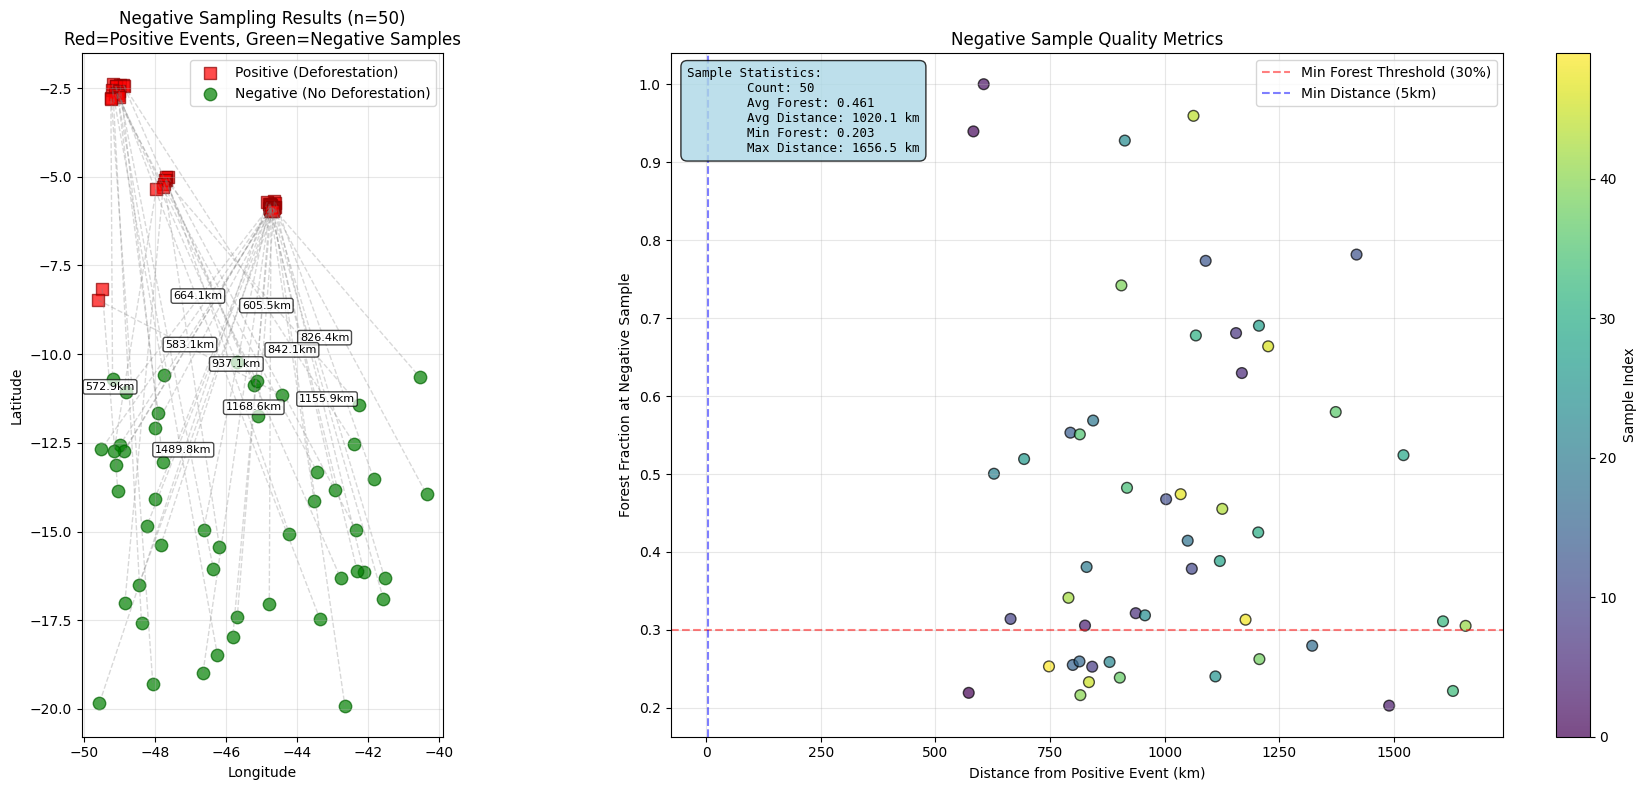


📈 Summary Statistics:
   Total negative samples: 50
   Forest fraction - Mean: 0.461, Range: 0.203-1.000
   Distance from positive - Mean: 1020.1km, Range: 572.9-1656.5km
   Sampling efficiency - Mean attempts: 3.2, Max: 12
   RADD tiles used: 1
   Tiles: 10S_050W

🗺️  Creating tile coverage map...
✓ Tile coverage map saved to: /net/home/lmaecker/own_projects/burned_embedder/data/interim/tile_coverage_map.png


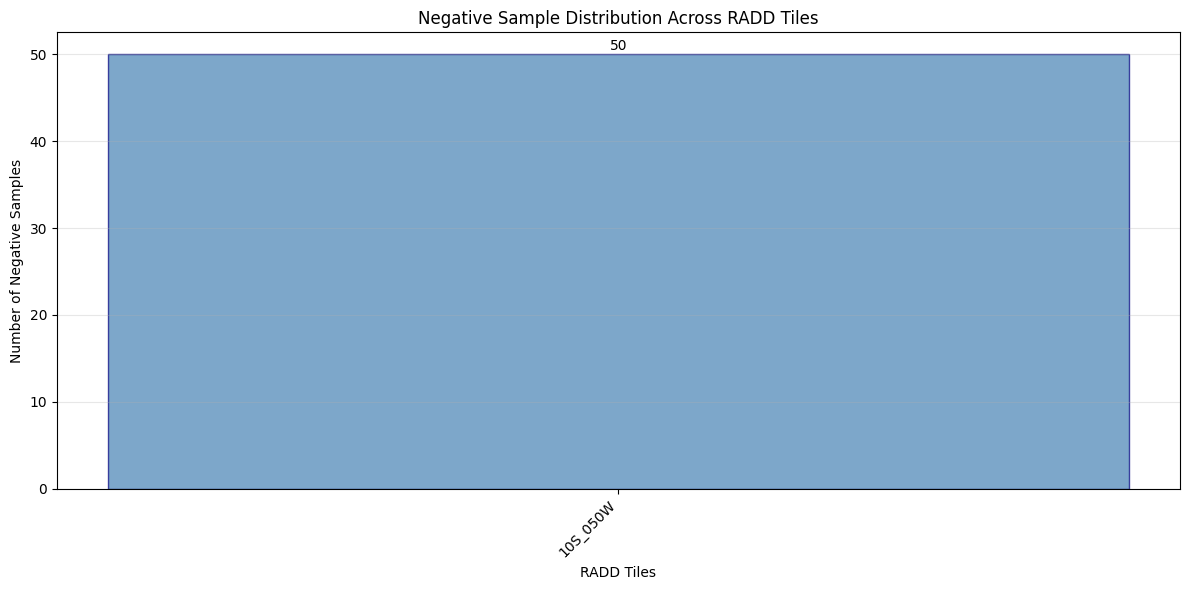

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import rootutils

root_path = rootutils.find_root()

def create_negative_samples_visualization(negative_samples_csv, deforest_parquet=None, max_samples=50):
    """
    Create visualization of negative samples generated by the sampling pipeline
    
    Args:
        negative_samples_csv: Path to CSV file with negative samples
        deforest_parquet: Optional path to original deforestation data
        max_samples: Maximum number of samples to plot (for readability)
    """
    print(f"📊 Creating visualization from: {negative_samples_csv}")
    
    # Load negative samples
    try:
        negative_df = pd.read_csv(negative_samples_csv)
        print(f"✓ Loaded {len(negative_df)} negative samples")
    except FileNotFoundError:
        print(f"❌ File not found: {negative_samples_csv}")
        return
    
    if len(negative_df) == 0:
        print("❌ No negative samples to visualize")
        return
    
    # Limit samples for readability
    if len(negative_df) > max_samples:
        negative_df = negative_df.head(max_samples)
        print(f"📊 Showing first {max_samples} samples for clarity")
    
    # Create plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot 1: Positive vs Negative locations
    ax1.scatter(negative_df['positive_lon'], negative_df['positive_lat'], 
               c='red', s=80, alpha=0.7, label='Positive (Deforestation)', marker='s', edgecolors='darkred')
    
    ax1.scatter(negative_df['lon'], negative_df['lat'], 
               c='green', s=80, alpha=0.7, label='Negative (No Deforestation)', marker='o', edgecolors='darkgreen')
    
    # Draw lines connecting positive to negative
    for idx, row in negative_df.iterrows():
        ax1.plot([row['positive_lon'], row['lon']], 
                [row['positive_lat'], row['lat']], 
                'gray', alpha=0.3, linewidth=1, linestyle='--')
    
    # Add distance annotations (for first 10 to avoid clutter)
    for idx, row in negative_df.head(10).iterrows():
        mid_lon = (row['positive_lon'] + row['lon']) / 2
        mid_lat = (row['positive_lat'] + row['lat']) / 2
        ax1.annotate(f"{row['distance_km']:.1f}km", 
                    (mid_lon, mid_lat), fontsize=8, ha='center', 
                    bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.7))
    
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    ax1.set_title(f'Negative Sampling Results (n={len(negative_df)})\nRed=Positive Events, Green=Negative Samples')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_aspect('equal', adjustable='box')
    
    # Plot 2: Sample quality metrics
    if 'forest_fraction' in negative_df.columns and 'distance_km' in negative_df.columns:
        # Scatter plot of forest fraction vs distance
        scatter = ax2.scatter(negative_df['distance_km'], negative_df['forest_fraction'], 
                            c=negative_df.index, cmap='viridis', s=60, alpha=0.7, edgecolors='black')
        
        ax2.set_xlabel('Distance from Positive Event (km)')
        ax2.set_ylabel('Forest Fraction at Negative Sample')
        ax2.set_title('Negative Sample Quality Metrics')
        ax2.grid(True, alpha=0.3)
        
        # Add threshold lines
        ax2.axhline(y=0.3, color='red', linestyle='--', alpha=0.5, label='Min Forest Threshold (30%)')
        if 'min_distance_km' in negative_df.columns:
            min_dist = negative_df['min_distance_km'].iloc[0] if not pd.isna(negative_df['min_distance_km'].iloc[0]) else 5
        else:
            min_dist = 5
        ax2.axvline(x=min_dist, color='blue', linestyle='--', alpha=0.5, label=f'Min Distance ({min_dist}km)')
        ax2.legend()
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax2)
        cbar.set_label('Sample Index')
        
        # Add statistics text
        stats_text = f"""Sample Statistics:
        Count: {len(negative_df)}
        Avg Forest: {negative_df['forest_fraction'].mean():.3f}
        Avg Distance: {negative_df['distance_km'].mean():.1f} km
        Min Forest: {negative_df['forest_fraction'].min():.3f}
        Max Distance: {negative_df['distance_km'].max():.1f} km"""
        
        ax2.text(0.02, 0.98, stats_text, transform=ax2.transAxes, 
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8),
                verticalalignment='top', fontsize=9, family='monospace')
    else:
        ax2.text(0.5, 0.5, 'Quality metrics not available\n(missing forest_fraction or distance_km)', 
                ha='center', va='center', transform=ax2.transAxes, fontsize=12)
        ax2.set_title('Quality Metrics Unavailable')
    
    plt.tight_layout()
    
    # Save plot
    plot_file = root_path / "data/interim/negative_samples_visualization.png"
    plt.savefig(plot_file, dpi=150, bbox_inches='tight')
    print(f"✓ Visualization saved to: {plot_file}")
    plt.show()
    
    # Print summary statistics
    print(f"\n📈 Summary Statistics:")
    print(f"   Total negative samples: {len(negative_df)}")
    if 'forest_fraction' in negative_df.columns:
        print(f"   Forest fraction - Mean: {negative_df['forest_fraction'].mean():.3f}, Range: {negative_df['forest_fraction'].min():.3f}-{negative_df['forest_fraction'].max():.3f}")
    if 'distance_km' in negative_df.columns:
        print(f"   Distance from positive - Mean: {negative_df['distance_km'].mean():.1f}km, Range: {negative_df['distance_km'].min():.1f}-{negative_df['distance_km'].max():.1f}km")
    if 'attempt_number' in negative_df.columns:
        print(f"   Sampling efficiency - Mean attempts: {negative_df['attempt_number'].mean():.1f}, Max: {negative_df['attempt_number'].max()}")
    
    # Show unique tiles used
    if 'tile_id' in negative_df.columns:
        unique_tiles = negative_df['tile_id'].nunique()
        print(f"   RADD tiles used: {unique_tiles}")
        if unique_tiles <= 10:
            print(f"   Tiles: {', '.join(negative_df['tile_id'].unique())}")

def create_tile_coverage_map(negative_samples_csv):
    """Create a simple map showing which RADD tiles were used"""
    negative_df = pd.read_csv(negative_samples_csv)
    
    if 'tile_id' not in negative_df.columns:
        print("No tile_id information available for coverage map")
        return
    
    # Count samples per tile
    tile_counts = negative_df['tile_id'].value_counts()
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Create bar plot of tile usage
    bars = ax.bar(range(len(tile_counts)), tile_counts.values, 
                  color='steelblue', alpha=0.7, edgecolor='navy')
    
    ax.set_xlabel('RADD Tiles')
    ax.set_ylabel('Number of Negative Samples')
    ax.set_title('Negative Sample Distribution Across RADD Tiles')
    ax.set_xticks(range(len(tile_counts)))
    ax.set_xticklabels(tile_counts.index, rotation=45, ha='right')
    
    # Add count labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{int(height)}', ha='center', va='bottom')
    
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    
    # Save
    plot_file = root_path / "data/interim/tile_coverage_map.png"
    plt.savefig(plot_file, dpi=150, bbox_inches='tight')
    print(f"✓ Tile coverage map saved to: {plot_file}")
    plt.show()

if __name__ == "__main__":
    # Path to your negative samples CSV
    negative_samples_file = root_path / "data/processed/radd/negative_samples.csv"
    
    print("🎨 Creating negative samples visualization...")
    
    if negative_samples_file.exists():
        # Main visualization
        create_negative_samples_visualization(negative_samples_file)
        
        # Tile coverage map
        print(f"\n🗺️  Creating tile coverage map...")
        create_tile_coverage_map(negative_samples_file)
        
    else:
        print(f"❌ Negative samples file not found: {negative_samples_file}")
        print("Run the negative sampling script first to generate the data.")